In [1]:
import spikeinterface.extractors as se
from pathlib import Path
import numpy as np
import spikeinterface as si
from readTrodesExtractedDataFile3 import readTrodesExtractedDataFile
import matplotlib.pyplot as plt

In [2]:
rec_folder = r"D:\cl\ephys\latency_20240904_144725.rec"

In [3]:
def get_dio_folders(rec_folder):
    # get the folder under rec_folder that ends with ".DIO"
    rec_folder = Path(rec_folder)
    dio_folders = [f for f in rec_folder.iterdir() if f.is_dir() and f.name.endswith(".DIO")]
    return dio_folders

In [4]:
dio_folders = get_dio_folders(rec_folder)
# reorder the dio_folders according to the name
dio_folders = sorted(dio_folders, key=lambda x: x.name)
dio_folders

[WindowsPath('D:/cl/ephys/latency_20240904_144725.rec/latency_20240904_144725.DIO'),
 WindowsPath('D:/cl/ephys/latency_20240904_144725.rec/latency_20240904_144725.part2.DIO')]

In [5]:
def extract_DIN(DIO_folder, channel_id):
    # get the file name
    DIO_folder = Path(DIO_folder)

    # file name is end with Din1.dat
    din_files = [f for f in DIO_folder.iterdir() if f.is_file() and f.name.endswith(f"Din{channel_id}.dat")]
    if len(din_files) == 0:
        # return error if no file found
        return None
    
    din_file = din_files[0]
    # read the file
    time = readTrodesExtractedDataFile(din_file)['data']['time']
    state = readTrodesExtractedDataFile(din_file)['data']['state']
    return time, state

In [6]:
def concatenate_din_data(dio_folders, channel_id: int):
    # initialize the din_data
    time, state = extract_DIN(dio_folders[0], channel_id)

    if len(dio_folders) == 1:
        return time, state
    
    
    for i in range(1, len(dio_folders)):
        time_, state_ = extract_DIN(dio_folders[i], channel_id)
        # if the end of the last state is the same as the start of the current state, remove the first element of the current state and time
        if state[-1] == state_[0]:
            state_ = state_[1:]
            time_ = time_[1:]

        time = np.concatenate((time, time_))
        state = np.concatenate((state, state_))
    return time, state

In [7]:
strobe_out_time, strobe_out_state = concatenate_din_data(dio_folders, 1)
indicator_time, indicator_state = concatenate_din_data(dio_folders, 2)

\\10.129.151.108\xieluanlabs\xl_cl\code\readTrodesExtractedDataFile3.py:64: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)


In [8]:
import numpy as np

def complete_time_series(indicator_time, indicator_state, time_series):
    # Ensure indicator_time and indicator_state are numpy arrays
    indicator_time = np.array(indicator_time)
    indicator_state = np.array(indicator_state)

    # Initialize the output array to store the state for each time in time_series
    completed_state = np.zeros_like(time_series, dtype=int)

    # Iterate through the time series and assign the state based on the indicator change points
    for i, t in enumerate(time_series):
        # Find the last indicator_time that is less than or equal to the current time
        idx = np.searchsorted(indicator_time, t, side='right') - 1
        
        if idx >= 0:
            # Assign the corresponding state
            completed_state[i] = indicator_state[idx]

    return completed_state

time_series = np.linspace(0, strobe_out_time[-1], strobe_out_time[-1])

completed_state = complete_time_series(indicator_time, indicator_state, time_series)


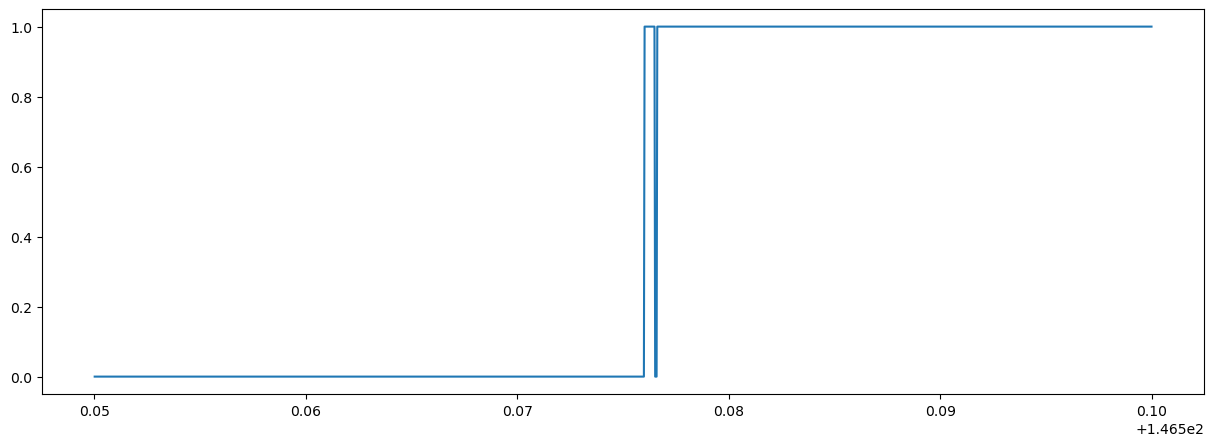

In [14]:
t = time_series/30000
t_range = (146.55,146.60)
# t_range = (146, 160)
# find the t index in the range
t_idx = np.where((t>=t_range[0]) & (t<=t_range[1]))[0]

plt.figure(figsize=(15,5))
plt.plot(t[t_idx], completed_state[t_idx])

In [10]:
# extract rising and falling edges time stamps
indicator_t = indicator_time/30000
rising_edges = indicator_t[np.where(indicator_state==1)]
falling_edges = indicator_t[np.where(indicator_state==0)][1:]

In [11]:
# delete all the fallings happens in 0.05s after a rising, and delete its corresponding next rising
falling_to_delete = np.where(falling_edges - rising_edges < 0.02)[0]
falling_edges = np.delete(falling_edges, falling_to_delete)
rising_edges = np.delete(rising_edges, falling_to_delete+1)

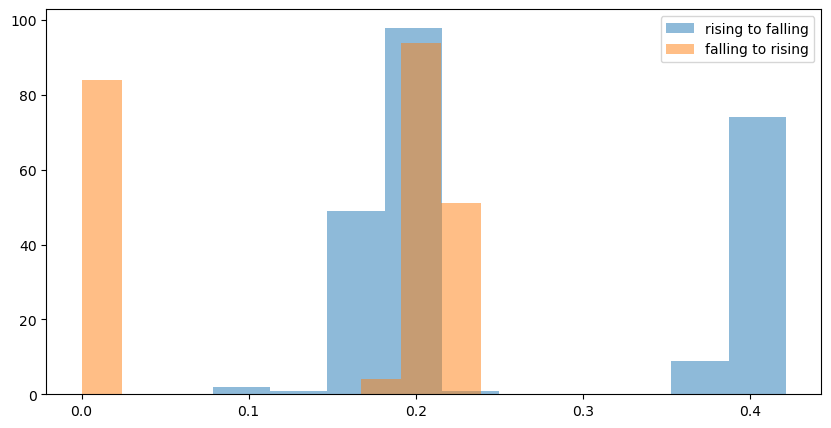

In [12]:
# get the rising to falling time and falling to rising time
rising_to_falling_time = falling_edges - rising_edges
falling_to_rising_time = rising_edges[1:] - falling_edges[:-1]

# plot the hist separately
plt.figure(figsize=(10,5))
plt.hist(rising_to_falling_time, bins=10, alpha=0.5, label='rising to falling')
plt.hist(falling_to_rising_time, bins=10, alpha=0.5, label='falling to rising')
plt.legend()

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,  33., 198.]),
 array([0.079     , 0.11326333, 0.14752667, 0.18179   , 0.21605333,
        0.25031667, 0.28458   , 0.31884333, 0.35310667, 0.38737   ,
        0.42163333]),
 <BarContainer object of 10 artists>)

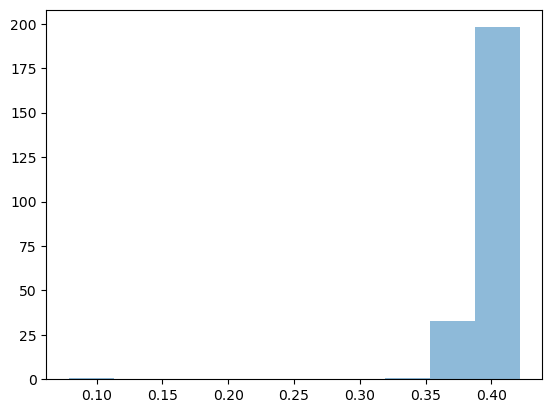

In [13]:
falling_to_falling_time = falling_edges[1:] - falling_edges[:-1]
plt.hist(falling_to_falling_time, bins=10, alpha=0.5, label='falling to falling')